In [350]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt

# Example programming the chain rule
Let $f(x) = (\sin(x^3))^2$. We can compose this into 

$$
f(x) = g(h(i(x)))\\
\text{where}\\
g(h) = h^2,\quad 
h(i) = \sin(i)\quad
i(x) = x^3
$$

$$
\frac{\partial f}{\partial x} = \frac{\partial g}{\partial x} = \frac{\partial g}{\partial h}\frac{\partial h}{\partial i}\frac{\partial i}{\partial x}
$$

In [98]:
def ref_f(x):
    return np.sin(x ** 3) ** 2

def ref_df(x):
    return 6 * (x**2) * np.sin(x**3) * np.cos(x**3)

In [163]:
class IdentityFunc():        
    def x(self, x):
        return x
    
    def dx(self, x):
        return 1

class Func():
    def __init__(self, g, g_prime, inner_f=IdentityFunc()):
        assert type(inner_f) in [IdentityFunc, Func]
        self.inner_f = inner_f
        self.g = g
        self.g_prime = g_prime
        
    def x(self, x):
        return self.g(self.inner_f.x(x))
    
    def dx(self, x):        
        """
        Uses chain rule with inner function to compute derivative with respect to x.
        """
        return self.g_prime(self.inner_f.x(x)) * self.inner_f.dx(x)

In [154]:
i = Func(lambda x: x**3, lambda x: 3 * x**2)
h = Func(lambda x: np.sin(x), lambda x: np.cos(x), inner_f=i)
g = Func(lambda x: x**2, lambda x: 2*x, inner_f=h)

In [162]:
x = randint(-100, 100)
print(f"Checking results with x = {x}.")
assert np.isclose(g.dx(x), ref_df(x)) and np.isclose(g.x(x), ref_f(x))
print("Confirmed!")

Checking results with x = 99.
Confirmed!


This setup here can do semi-automatic differentiation I suppose. It can only differentiate with respect to a single variable and makes the user specify the derivates of the simpler more composable functions. I don't think this would extend well enough to be able to be effective in a neural network backprop algorithm.

If we want to extend this to be able to differentiate w.r.t. many input variables, we need to build a more complete graph or tree structure like tensorflow does. Side note: does pytorch
also create a graph? 

## Toy NN
Image we have a simple NN with 1 input neuron, 2 hidden neurons, and 1 output neuron.
$$
a^{(1)}_1 \rightarrow a^{(2)}_1 \rightarrow a^{(3)}_1 \rightarrow a^{(4)}_1
$$
We can describe the computation graph of the NN with
$$
a^{(1)} = \text{input}\\
a^{(k)} = \sigma(z^{k})\\
z^{(k)} = w^{(k)} a^{(k-1)} + b^{(L)}\\
\sigma(x) = \text{ReLU} = \max(0, x)
$$
where $w^{(k)}_{mn}$ is the weight applied to activation $a_n^{(k-1)}$ going to activation $a_m^{(k)}$. Similarly, $b^{(k)}_{m}$ is the bias applied to activation $a_m^{(k)}$. We will drop the subscripts because our network has layers with a single neuron each. If our layers had more neurons, we would keep it.

We will also define a cost function $C$ given inputs $X = \{x_1, \dots, x_n\}$ where $x_i \in \mathbb{R}$ and $Y = \{y_1, \dots, y_n\}$ where $y_i \in \{0, 1\}$.
$$
C(\vec{w}, \vec{b}, X, Y) = \frac{1}{n} \sum_{i=1}^n \big(a^{(L)}(x_i) - y_i\big)^2
$$

If we minimize $C$ with respect to $\vec{w}$ and $\vec{b}$ we optimize the network. We can use stochastic gradient descent to iteratively minimize $C$ and backprop is the means to calculate the gradient.

In [164]:
def relu_x(x):
    if x > 0:
        return x
    else:
        return 0
    
def relu_dx(x):
    if x > 0:
        return 1
    else:
        return 0

In [1179]:
w_1, w_2, w_3 = 1, 1, 1
b_1, b_2, b_3 = 0, 0, 0

# differentiable w.r.t anything
a1 = Func(lambda x: x, lambda x: 1)

# differentiable w.r.t w's
w_a2_pre_activation = Func(lambda x: w_1 * x + b_1, lambda x: x, inner_f=a1)
w_a2 = Func(relu_x, relu_dx, inner_f=w_a2_pre_activation)

w_a3_pre_activation = Func(lambda x: w_2 * x + b_2, lambda x: x, inner_f=w_a2)
w_a3 = Func(relu_x, relu_dx, inner_f=w_a2_pre_activation)

w_a4_pre_activation = Func(lambda x: w_3 * x + b_2, lambda x: x, inner_f=w_a3)
w_a4 = Func(relu_x, relu_dx, inner_f=w_a4_pre_activation)

# this is the problem with forward differentiation -> the paths get ridiculous

# Conclusion

It starts to get really hard to differentiate this w.r.t all the varaibles we neet to calculate in our gradient. At least programatically in the way I've set up semi-differentiable functions. Backpropogation / reverse differentiation helps here.

## What about JAX

In [1064]:
import jax.numpy as jnp
from jax import grad, jit
import jax

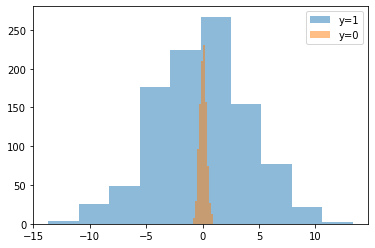

In [1323]:
# make some sample data to classify
import sklearn

x_1 = np.random.normal(0, 4, 1000)
x_0 = np.random.normal(0, 0.3, 1000)


X = np.concatenate((x_1, x_0))
Y = np.concatenate((np.ones_like(x_1), np.zeros_like(x_0)))

X, Y = sklearn.utils.shuffle(X, Y)

plt.figure()
plt.hist(X[Y == 1], alpha=0.5, label='y=1')
plt.hist(X[Y == 0], alpha=0.5, label='y=0')
plt.legend()
plt.show()

X = jnp.array(X).reshape(-1, 1)
Y = jnp.array(Y)

In [1324]:
class Layer():
    def __init__(self, size, activation_fn=jax.nn.relu, input_layer=False):
        self.size = size
        self.activation_fn = activation_fn
        self.is_input_layer = input_layer
        
class SimpleNeuralNet():
    def __init__(self, layers):
        self.num_layers = len(layers)
        
        sizes = list(map(lambda l: l.size, layers))
        weight_shapes = zip(sizes[:-1], sizes[1:])
        bias_lengths = sizes[1:]
        
        self.w = [ jnp.array(np.random.normal(0, 1, shape)) for shape in weight_shapes ]
        self.b = [ jnp.array(np.random.normal(0, 1, length)) for length in bias_lengths ]
        self.activations = list(map(lambda l: l.activation_fn, layers[1:]))
        
        self._model = self._forward_model()
        self._cost, self._cost_gradient = self._cost_fn()
        
    def _forward_model(self):
        n = self.num_layers
        activations = self.activations
        
        def model(w, b, X):
            state = X
            for i in range(n-1):
                state = activations[i](jnp.matmul(state, w[i]) + b[i])     
            return state
        
        return model
    
    def cost(self, X, y):
        return self._cost(self.w, self.b, X, y)
    
        
    def predict(self, X):
        y_hat = (self._model(self.w, self.b, X) > 0.5)
        return y_hat
    
    def accuracy(self, X, y):
        y_hat = self.predict(X)
        y = y.reshape(y_hat.shape)
        return jnp.mean(y == y_hat)
    
    def _cost_fn(self):
        model = self._model
        
        def cost(w, b, X, y):
            return jnp.mean((model(w, b, X) - y) ** 2)
        
        return jit(cost), jit(grad(cost, argnums=(0, 1)))
    
    
    def update(self, X, y, step_size=.1, iters=500):
        _, gradient = self._cost_fn()
        y = y.reshape(-1, self.b[-1].shape[0])
        
        for i in range(iters):
            weight_grad, bias_grad = gradient(self.w, self.b, X, y)
            for idx, wg in enumerate(weight_grad):
                self.w[idx] += -(wg * step_size)

            for idx, bg in enumerate(bias_grad):
                self.b[idx] += -(bg * step_size)

In [1325]:
def status(snn, plot=False):
    y_hat = snn.predict(X)
    print(f"Accuracy: {snn.accuracy(X, Y):0.2f}")
    print(f"Cost: {snn.cost(X, Y):0.2f}")

    
    if not plot:
        return

    # what does our NN do
    plt.figure()
    plt.hist(np.array(X[y_hat == 1]), alpha=0.5, label='y=1')
    plt.hist(np.array(X[y_hat == 0]), alpha=0.5, label='y=0')
    plt.legend()
    plt.show()

Accuracy: 0.34
Cost: 0.48


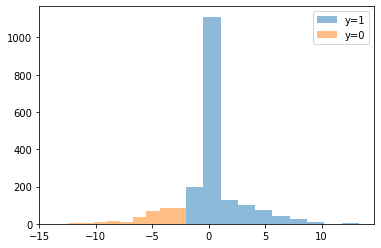

In [1328]:
layers = [
    Layer(1, input_layer=True),
    Layer(12),
    Layer(8),
    Layer(1, activation_fn=jax.nn.sigmoid)
]
snn = SimpleNeuralNet(layers)
cost, _ = snn._cost_fn()
status(snn, plot=True)

Accuracy: 0.34
Cost: 0.48
Accuracy: 0.91
Cost: 0.42
Accuracy: 0.91
Cost: 0.42
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43
Accuracy: 0.91
Cost: 0.43


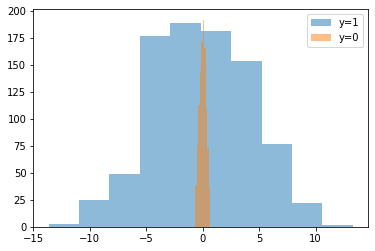

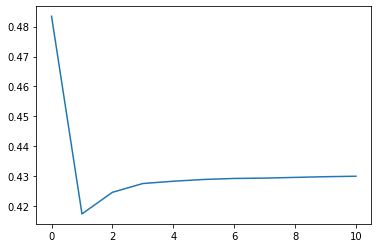

In [1329]:
losses = []
losses.append(snn.cost(X, Y))


status(snn)
for i in range(10):
    snn.update(X, Y, iters=200)
    status(snn)
    losses.append(snn.cost(X, Y))
    
status(snn, plot=True)

plt.figure()
plt.plot(losses)
plt.show()

# More manual NN in JAX

In [1306]:
# define our NN
def nn(w1, w2, w3, b1, b2, b3, x):
    in_layer = x
    
    # hidden layer 1, fully connected 1->n neurons
    l1_size = 40
    w1 = w1.reshape(l1_size, 1)
    l1 = jax.nn.relu(jnp.matmul(x, w1.T) + b1)
                     
    # hidden layer 2, fully connected n->m neurons
    l2_size = 40
    w2 = w2.reshape(l2_size, l1_size)
    l2 = jax.nn.relu(jnp.matmul(l1, w2.T) + b2)

    # activation layer, fully connected m->1 neurons
    l3_size = 1
    w3 = w3.reshape(l3_size, l2_size)
    l3 = jax.nn.sigmoid(jnp.matmul(l2, w3.T) + b3)
    
    return l3.reshape(-1)

def cost(w1, w2, w3, b1, b2, b3, x, y):
    return jnp.mean((nn(w1, w2, w3, b1, b2, b3, x) - y) ** 2)

def predict(w1, w2, w3, b1, b2, b3, x):
    return jnp.where(nn(w1, w2, w3, b1, b2, b3, x) > 0.2, 1, 0)

def accuracy(w1, w2, w3, b1, b2, b3, x, y):
    return jnp.mean(predict(w1, w2, w3, b1, b2, b3, x) == y)

Cost: 0.49998244643211365
Accuracy: 0.5


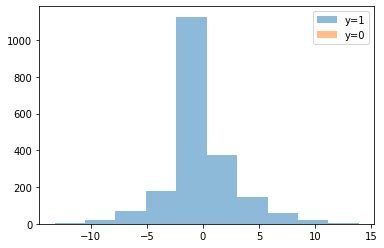

In [1189]:
sizes = [40, 40]

ws = [
    jnp.array(np.random.normal(0, 1, sizes[0])),
    jnp.array(np.random.normal(0, 1, sizes[0] * sizes[1])),
    jnp.array(np.random.normal(0, 1, sizes[1]))
]

bs = [
    jnp.array(np.random.normal(0, 1, sizes[0])),
    jnp.array(np.random.normal(0, 1, sizes[1])),
    jnp.array(np.random.normal(0, 1, 1)),
]


print("Cost:", float(cost(*ws, *bs, X, Y)))
print("Accuracy:", float(accuracy(*ws, *bs, X, Y)))

# what does our NN do
y_hat = predict(*ws, *bs, X)
plt.figure()
plt.hist(np.array(X[y_hat == 1]), alpha=0.5, label='y=1')
plt.hist(np.array(X[y_hat == 0]), alpha=0.5, label='y=0')
plt.legend()
plt.show()

In [1190]:
fastgrad = jit(grad(cost, argnums=(0,1,2,3,4,5)))

In [1191]:
# keep running this and watch the cost go down
losses = []
for j in range(10):
    for i in range(500):
        w1_grad, w2_grad, w3_grad, b1_grad, b2_grad, b3_grad = fastgrad(*ws, *bs, X, Y)
        step_size = 0.1

        ws[0] = ws[0] - w1_grad * step_size
        ws[1] = ws[1] - w2_grad * step_size
        ws[2] = ws[2] - w3_grad * step_size

        bs[0] = bs[0] - b1_grad * step_size
        bs[1] = bs[1] - b2_grad * step_size
        bs[2] = bs[2] - b3_grad * step_size

    losses.append(cost(*ws, *bs, X, Y))
    print("Cost:", float(cost(*ws, *bs, X, Y)))
    print("Accuracy:", float(accuracy(*ws, *bs, X, Y)))

Cost: 0.07424373179674149
Accuracy: 0.8950000405311584
Cost: 0.0682714581489563
Accuracy: 0.8675000667572021
Cost: 0.06796593219041824
Accuracy: 0.8645000457763672
Cost: 0.06786619871854782
Accuracy: 0.862500011920929
Cost: 0.06780803203582764
Accuracy: 0.8610000610351562
Cost: 0.06777559220790863
Accuracy: 0.8615000247955322
Cost: 0.06773004680871964
Accuracy: 0.862500011920929
Cost: 0.06770588457584381
Accuracy: 0.8605000376701355
Cost: 0.06768827885389328
Accuracy: 0.8605000376701355
Cost: 0.06767383217811584
Accuracy: 0.8605000376701355


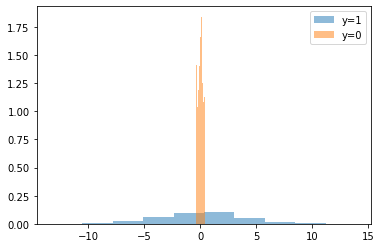

In [1192]:
# what does our NN do
y_hat = predict(*ws, *bs, X)
plt.figure()
plt.hist(np.array(X[y_hat == 1]), density=True, alpha=0.5, label='y=1')
plt.hist(np.array(X[y_hat == 0]), density=True, alpha=0.5, label='y=0')
plt.legend()
plt.show()

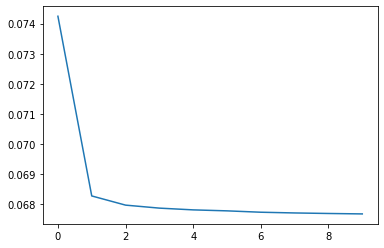

In [1193]:
plt.figure()
plt.plot(losses)
plt.show()